<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/twyncoder/dl-handson-tcb/blob/master/L03_TrainAdvDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Redes de Aprendizaje Profundo básicas con Keras y Tensorflow.
## *Deep Neural Networks (DNN) para clasificación multi-clase*

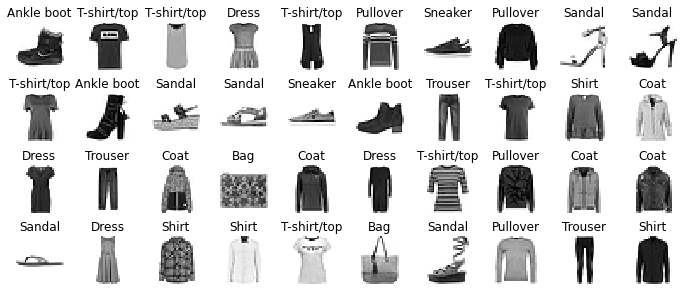

## 0. Preparación del entorno y comprobación de requisitos

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import pandas as pd

# Where to save the figures
PROJECT_ROOT_DIR = "."
SUBFOLDER = "HandsOn_03"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", SUBFOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

RND_SEED = 40

### Información de versiones

In [2]:
tf.__version__

'2.4.2'

In [3]:
keras.__version__

'2.4.0'

### Comprobar si disponemos de una GPU

In [ ]:
tf.config.list_physical_devices('GPU')

## 1. Dataset

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
X_train, X_valid = X_train_full[:55000], X_train_full[55000:]
y_train, y_valid = y_train_full[:55000], y_train_full[55000:]
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

## 2. Entrenamiento

### Modelo 'base' de red neuronal

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


**¡AHORA TÚ!**
- Entrena la red anterior usando _Stochastic Gradient Descent_ durante 35 `epochs` y con un  `learning_rate` de 1e-2 .
- Muestra en una gráfica la evolución del entrenamiento. ¿Se produce sobreentrenamiento?

### Variación dinámica del learning rate
- Una forma de prevenir el sobreentrenamiento es ir disminuyendo de manera dinámica el _learning rate_.
- De hecho, algunos optimizadores lo hacen internamente de manera automática.
- Podemos elegir distintas estrategias para ir disminuyendo el _learning rate_.

#### Power scheduling
```lr = lr0 / (1 + steps*decay)```

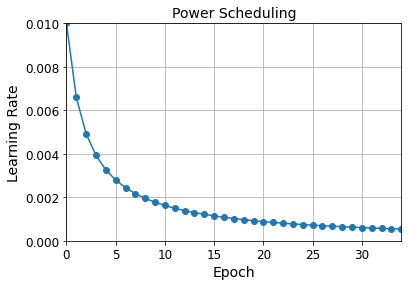

In [11]:
import math

learning_rate = 1e-2
decay = 3e-4
batch_size = 32
n_epochs = 35
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
steps = epochs * n_steps_per_epoch
lrs = learning_rate / (1 + decay * steps)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 1e-2])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [12]:
#optimizer = keras.optimizers.SGD(learning_rate=5e-3, decay=<<TODO>>)

**¡AHORA TÚ!**
- Teniendo en cuenta que el tamaño del batch por defecto en keras es 32, observa la gráfica anterior.
- Prueba a entrenar con alguna configuración variando `decay` y averigua si puedes controlar el sobreentrenamiento.
- Emplea un _callback_ para imprimir la relación entre `val_loss`y `loss`.

### Exponential scheduling
- Keras dispone de planificadores _out-of-the-box_, por ejemplo para decrecimiento exponencial del `learning_rate`.
- `initial_learning_rate * decay_rate ^ (step / decay_steps)`

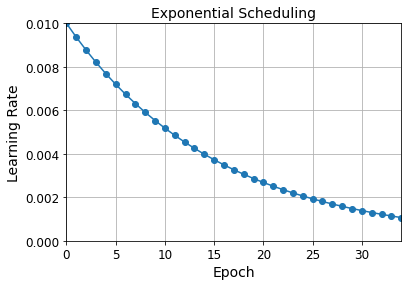

In [16]:
learning_rate = 1e-2
decay_rate = 0.1
batch_size = 32
n_epochs = 35
n_steps_per_epoch = math.ceil(len(X_train) // batch_size)
decay_steps = n_epochs * n_steps_per_epoch

epochs = np.arange(n_epochs)
steps = epochs * n_steps_per_epoch

lrs = learning_rate * np.power(decay_rate,steps/decay_steps)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 1e-2])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [17]:
epochs = 35
batch_size = 32 
total_steps = epochs * (len(X_train) // batch_size)
initial_learning_rate = 1e-2
decay_rate = 0.1
lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,total_steps,decay_rate)
optimizer = keras.optimizers.SGD(learning_rate=lr)



**¡AHORA TÚ!**

- Prueba a entrenar con este optimizador modificado.

### Performance scheduling (Reduce on plateau)
- También es posible añadir un _callback_ para que se reduzca el `learning_rate` cuando el _loss_ se queda en una meseta. Busca información e indica qué controlan los argumentos `monitor`, `factor` y `patience`.

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.4, patience=2)

- Observa que también es posible escribir _callbacks_ para informar del learning rate al final de cada _epoch_

In [21]:
class PrintLrCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        # - CUIDADO: Imprimir lr para ver variación no funciona cuando no se usa un callback de keras que actualiza lr internarmente. El lr impreso es constante.
        print("Learning rate: {:.6f}: ".format(keras.backend.eval(self.model.optimizer.learning_rate)))
        
lr_cb = PrintLrCallback()

**¡AHORA TÚ!**
- Añade los _callbacks_ `lr_scheduler` y `lr_cb` durante el entrenamiento.
- Para ejecutar varios _callback_ puedes hacer una lista en la llamada a la función `fit`.

## Técnicas de regularización

### Regularización L1 y L2 

- Podemos incluir regularización L2 con factor 0.01 en las capas Dense de la siguiente manera:

<code> layer = keras.layers.Dense(100, activation="elu",                   
                      kernel_initializer="he_normal",                 
                      kernel_regularizer=keras.regularizers.l2(0.01)) </code> 
 - `l1(0.1)` para L1 con factor 0.1
 - `l1_l2(0.1, 0.01)` para L1 y L2 con factores 0.1 y 0.01 respectivamente

**¡AHORA TÚ!**
- Modifica la red neuronal base de este _notebook_ para regularizar las capas ocultas con L2 y observa si disminuye el sobreentrenamiento.
- Utiliza un `learning_rate` _agresivo_ de 1e-2. No utilices ninguna técnica de planificación para disminuirlo durante el entrenamiento.
- ¿Qué tal ha ido el entrenamiento esta vez? ¿Qué valores se han obtenido de `val_accuracy` y `accuracy`?

**¡AHORA TÚ!**
- Prueba ahora a utilizar otro optimizador distinto de _SGD_ junto con otro valor de `learning_rate`y trata de conseguir un rendimiento similar sin utilizar un número tan elevado de `epochs`.

### Dropout
- Puedes introducir capas de Dropout de la siguiente manera.
- Explica cómo se interpreta el _dropout_ `rate` y prueba a entrenar el nuevo modelo.

`keras.layers.Dropout(rate=0.2)`


Epoch 1/35
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7264 - accuracy: 0.7409 - val_loss: 0.4216 - val_accuracy: 0.8394
Epoch 2/35
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4709 - accuracy: 0.8259 - val_loss: 0.4003 - val_accuracy: 0.8536
Epoch 3/35
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4277 - accuracy: 0.8445 - val_loss: 0.3668 - val_accuracy: 0.8636
Epoch 4/35
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3962 - accuracy: 0.8545 - val_loss: 0.3597 - val_accuracy: 0.8648
Epoch 5/35
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3783 - accuracy: 0.8591 - val_loss: 0.3289 - val_accuracy: 0.8766
Epoch 6/35
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3704 - accuracy: 0.8646 - val_loss: 0.3544 - val_accuracy: 0.8726
Epoch 7/35
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3535 - accuracy: 0.8684 - val_loss: 0.3319 - val_accuracy:

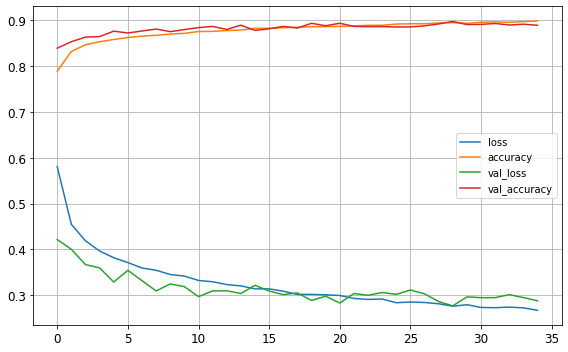

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=35,
                    validation_data=(X_valid, y_valid))

### Early Stopping

- Parar el entrenamiento es una forma de prevenir que la red sobreentrene. Se puede dejar a la red que siga entrenando durante un tiempo, pero utilizar después en la etapa de inferencia los parámetros que proporcionaron mejor loss de validación (distintos de los de la última _epoch_).

In [42]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_dnn_model.h5", save_best_only=True)

**¡AHORA TÚ!**
- Utiliza los _callbacks_ anteriores y lanza un entrenamiento análogo al que lanzamos en el apartado de _Dropout_.

## 3. Test

In [46]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 771us/step - loss: 0.3328 - accuracy: 0.8806


[0.3327644467353821, 0.8805999755859375]

In [47]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Matriz de confusión

In [48]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = np.argmax(model.predict(X_test),axis=-1)
conf = confusion_matrix(y_true, y_pred)
print(conf)

[[849   2   4  24   3   0 106   0  12   0]
 [  3 966   1  24   2   0   3   0   1   0]
 [ 17   0 764  13  89   0 115   0   2   0]
 [ 16   3   6 921  19   0  31   0   3   1]
 [  0   0  74  60 748   0 115   0   3   0]
 [  0   0   0   1   0 926   0  37   2  34]
 [125   0  58  35  44   0 726   0  12   0]
 [  0   0   0   0   0   5   0 954   0  41]
 [  3   0   2   6   2   2   4   4 977   0]
 [  0   0   0   0   0   1   1  23   0 975]]


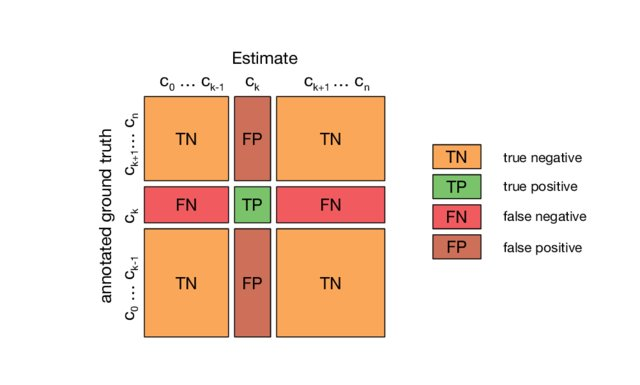

### Métricas de rendimiento

In [49]:
TP = np.diag(conf)
FP = conf.sum(axis=0) - TP 
FN = conf.sum(axis=1) - TP
TN = conf.sum() - (FP + FN + TP)

**¡AHORA TÚ!**
- Haciendo uso de la imagen de matriz de confusión para problemas multiclase, verifica que los cálculos sean correctos. Puedes imprimir los vectores `TP`, `FP`, `FN` y `TN` para hacer una comprobación rápida.

**¡AHORA TÚ!**
- Calcula e imprime las siguientes métricas para cada clase con dos decimales de precisión:
    - Precision:                     
    $PPV = TP/(TP+FP)$
    - Sensitivity (Recall):  
    $TPR = TP/(TP+FN)$
    - Specificity:           
    $TNR = TN/(TN+FP)$
    - Accuracy:             
    $ACC = (TP+TN)/(TP+FP+FN+TN)$
    - F1-score:             
    $FONE = 2*TP/(2*TP + FP + FN)$

In [51]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

**¡AHORA TÚ!**
- Calcula ahora las siguientes métricas y muéstralas con tres decimales:
 - Mean Per Class Accuracy (MPCA): media de _accuracy_ respecto a todas las clases. 
 - Mean Average Precision (mAP): media de _precision_ respecto a todas las clases.